# Mapas Auto-Organizáveis(SOM) - Outliers

In [1]:
import pandas as pd
import numpy as np
from minisom import MiniSom

## Obter os dados

In [2]:
# 0: cliente aprovado para crédito.
# 1: cliente não aprovado para crédito.
# O objectivo é detectar os clientes que foram aprovados para crédito e que possam vir a fazer algum tipo de fraude

data = pd.read_csv("credit-data.csv")

## Pré-Processamento dos dados - Valores ausentes

In [3]:
# Só existem 3 valores ausentes nos dados
data.isnull().sum()

clientid    0
income      0
age         3
loan        0
default     0
dtype: int64

In [4]:
# Como apenas 3 linhas têm valores ausentes optou-se por apagar essas linhas.
data = data.dropna()

## Pré-Processamento dos dados - Valores inconsistentes

In [5]:
# Existem clientes com idade inferior a 0.
# A sua idade será substituida pela média das idades
data[data["age"]<0]

,clientid,income,age,loan,default
15,16,50501.726689,-28.218361,3977.287432,0
21,22,32197.620701,-52.423280,4244.057136,0
26,27,63287.038908,-36.496976,9595.286289,0


In [6]:
data["age"].mean()

40.80755937840458

In [7]:
data.loc[data.age<0, "age"] = 40.92

In [8]:
# Confirmação de que já não existem clientes com idade inferior a 0.
data[data["age"]<0]

,clientid,income,age,loan,default


## Divisão dos dados

In [9]:
# Utiliza-se a coluna clienteid para ser possivel recuperar o nome do cliente que pode fazer uma fraude.
X = data.iloc[:,0:4].values

In [10]:
y = data.iloc[:,4].values

## Normalização das Variaveis

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
# Passar os dados de entrada para uma escala de 0 a 1 para que o processamento dos dados seja mais rapido e tambem para não 
# haver variaveis que pela sua escala tenham mais influência no modelo(para não haver variáveis dominantes).
scaler = MinMaxScaler(feature_range=(0,1))

In [13]:
# Ajustar a variavel X para fazer a sua normalização.
scaler.fit(X)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [14]:
# Normalização da variavel X.
X = scaler.transform(X)

## Modelo do Mapa Auto-Organizável

In [15]:
# x: numero de linhas da matriz de saida
# y: numero de colunas da matriz de saida
# input_ten: número de variaveis de entrada
# sigma: Alcançe do raio traçado com o centro nos BMU e utilizado para a actualização dos seus vizinhos. 
# learning_rate: taxa de aprendizagem utilizada para a actualização do BMU e aproximação do seu valor ao valor do registro (e
# consequente actualização dos valores vizinhos).
# random_seed: Obter sempre o mesmo resultado para o modelo. A inicialização dos pesos tem sempre o mesmo valor.

# ransom_weights_init: Inicialização dos pesos da base de dados
# train_random: Treinar o modelo (num_iteration = número de epocas)

# 5xsqr(N), sendo N o nº de registros. Para 293 registros: 5xsqr(293) = 223 celulas = matriz 15x15.

model = MiniSom(x=15, y=15, input_len=4, sigma=1, learning_rate=0.5, random_seed=0)
model.random_weights_init(X)
model.train_random(data=X, num_iteration=100)

## Visualização dos resultados

In [16]:
from pylab import pcolor, colorbar, plot

### Mapa da distância entre neurónios

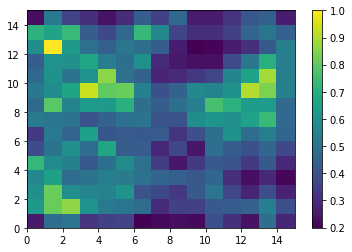

In [17]:
# distance_map().T: Matriz transposta com os valores de distancia MID.
# MID: Média da distancia eucladiana entre um neurónio e os neurónios à sua volta.

# MID - mean inter neuron distance: usada para avaliar quanto um neurónio é parecido aos seus vizinhos.

# Quanto maior o valor da distancia, maior a diferença entre o neurónio e os seus vizinhos
# Como se está a utilizar valores entre 0 e 1. 1 é a maxima distancia possivel e 0 é a minima distancia possivel.

# Quanto mais escuro(azul) menor é a distancia do neurónio para os vizinhos(o neurónio é mais semelhante aos vizinhos).
# Usado para avaliar se um detrminado registro se enquadra no padrão. Por exemplo os neurónios amarelos não são tão confiaveis
# por serem muito diferentes aos neurónios vizinhos. 

# Ou seja os registros a amarelo podem ser Outliers. Clientes com uma probabilidade alta de cometer algum tipo de fraude.

pcolor(model.distance_map().T)
colorbar()

### Mapa Auto-Organizável

In [18]:
# Lista com os marcadores
# "o" neurónio pertence à classe 0
# "s" neurónio pertence à classe 1
markers = ["o","s"]

In [19]:
# Lista com as cores
colors = ["r","g"]

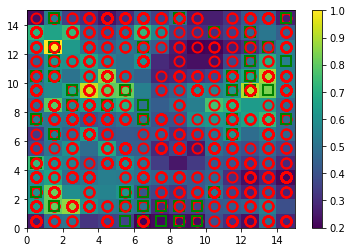

In [20]:
# i: indice de X
# x: linha inteira de X
# w: BMU de cada linha

# (+0.5)posicionar o simblo no meio do neurónio

pcolor(model.distance_map().T)
colorbar()

for i,x in enumerate(X):
    w = model.winner(x)
    plot(w[0] + 0.5, w[1] + 0.5, markers[y[i]], markerfacecolor="None", 
    markersize=10, markeredgecolor=colors[y[i]], markeredgewidth=2) 

In [26]:
# Sendo os neurónios da classe 0 os que têm os marcadores vermelhos e os outliers os neurónios amarelos, os clientes a quem foi
# atribuido crédito(classe 0) com maior probabilidade de cometer fraude(outliers) são a junção dos 2. Neurónios amarelos com
# marcadores vermelhos.

# mapeamento: Dicionário com os registros que escolheram o neurónio como BMU.
# suspeitos: Array com os neurónios suspeitos(Amarelos). Poderiam ter sidos escolhidos mais neurónios como o (3,9).
# Os registros que escolheram esse neurónio(Amarelo) como BMU têm grande probabilidade de serem outliers. Caso se aumente o 
# número de épocas a possição dos nerónios amarelos é alterada.

mapeamento = model.win_map(X) 
suspeitos = np.concatenate((mapeamento[(13,10)], mapeamento[(1,12)], ), axis=0) 
suspeitos = scaler.inverse_transform(suspeitos) # inverter a normalização para obter o clientid

In [32]:
# classe: Classe a que pertencem os suspeitos.
# Se pertencerem à classe 0 são clientes a quem o crédito foi aprovado e são clientes com alta probabilidade de cometer fraude.
# Se pertencerem à classe 1 são clientes a quem o crédito não foi aprovado mas com alta probabilidade de cometer fraude.

classe = []
for i in range(len(data)):
    for j in range(len(suspeitos)):
        if data.iloc[i, 0] == int(round(suspeitos[j,0])):
            classe.append(data.iloc[i,4])           

In [34]:
classe = np.array(classe)
classe

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
      dtype=int64)

In [46]:
suspeitos_final = np.column_stack((suspeitos, classe)) # juntar os suspeitos e a classe
suspeitos_final = suspeitos_final[suspeitos_final[:,4].argsort()] # ordenar de forma crescente pela coluna 4

In [48]:
suspeitos_final = pd.DataFrame(suspeitos_final)
suspeitos_final.columns = ["clientid","income","age","loan","default"]
suspeitos_final

,clientid,income,age,loan,default
0,1350.0,39393.140578,52.739274,5415.054667,0.0
1,1902.0,49048.757360,52.051794,6363.113668,0.0
2,1923.0,40506.944007,52.241514,5961.531816,0.0
3,1928.0,41183.824656,56.032365,7606.993239,0.0
4,1956.0,48500.268154,61.304800,7054.606149,0.0
5,1719.0,58809.292472,37.459189,5470.587846,0.0
6,1760.0,59568.624320,40.558919,7685.326744,0.0
7,1840.0,48614.849679,61.301293,5984.950784,0.0
8,1842.0,57745.358876,36.729610,5540.464047,0.0
9,1850.0,55763.427417,30.585448,7913.837734,0.0
